Using TensorFlow backend.


170500096/170498071 [==============================] - 13s 0us/step












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_______________________________________________________

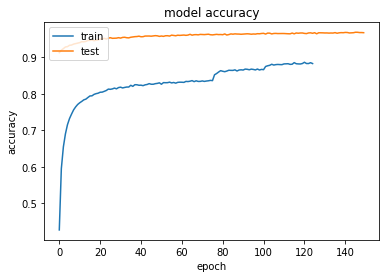

In [ ]:
##########################DM########################
from __future__ import print_function
import tensorflow as tf
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import LearningRateScheduler
from keras.optimizers import adam
from keras.callbacks import EarlyStopping
from keras import regularizers
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
 
#Chargement des données de cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
 
###Convert to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
 
###Normalize inputs from [0; 255] to [0; 1]
x_train = x_train / 255
x_test = x_test / 255
 
###Préparation pour couche neuronnale
num_classes = 10
 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
 
###Learning rate
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate
 
def cnn():
    weight_decay = 1e-4
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
     
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))
     
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))
     
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    
    opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
    return model
 
###creation du reseau
 
model = cnn()
model.summary()
 
###entrainement
batch_size=32
epochs=150
 
#construct the training image generator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)
 
#stops when acc doesn't change anymore
earlystopper = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
 
# phase 1 train / Data augmentation
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=125,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])
 
# phase 2 train / Normal
hist2 = model.fit(x_train, y_train,
            validation_data=(x_test, y_test),
            epochs=epochs,
            batch_size=batch_size)   
 
###evaluation
 
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: ', score[0])
print('Test accuracy: ', score[1])
#plot accuracies
plt.plot(hist.history['acc'])
plt.plot(hist2.history['acc'])
#plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **Explications de la démarche** :

##I. Chargement des données de cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

A partir de cette ligne de code, on obtient :
- l'ensemble des données d'entraînement (x_train et y_train)
- l'ensemble des données de test (x_test et y_test)

Ces deux ensembles seront nécessaires à la suite de TP.

##II. Convertion en float32

Il est commun d'utiliser une précision de 32 bit pour entraîner un réseau de neuronnes, et comme nous l'avions fait également en TD, nous avons donc converti l'ensemble d'entraînement en 32 bit floats.

##III. Normalisation de l'entrée de [0; 255] à [0; 1]

Par rapport à la division par 255, c'est la valeur maximale qu'un bit peut prendre (le type de l’entrée avant la conversion en float32), cela va donc transformer les données d'entrée pour les mettre dans des valeurs entre 0.0 et 1.0. 

On préfère généralement avoir des fonctionnalités d’entrée sur cette échelle afin que le taux d’apprentissage par défaut (et d’autres hyperparamètres) fonctionnent raisonnablement bien.

##V. Préparation pour la couche neuronnale

Nous avons initialisé une variable num_classes à 10, puisqu'il y a 10 classes par rapport à cifar10, et cette variable nous sera utile quand il faudra créer la dernière couche neuronnal de sortie avec la fonction d'activation softmax.

Les keras.utils.to_categorical des y_train et y_test sont nécessaires pour convertir ces vecteurs de classe (type entier) en matrices de classe binaire. On en a besoin impérativement pour l'utilisation de categorical_crossentropy (fonction de perte) dans notre couche de neuronnes.

##VI. Learning rate

Nous avons implémenté une fonction lr_schedule qui prend en paramètre le nombre d'epochs actuels et qui sera utilisé en "callback" pour le model.fit_generator (entraînement du réseau avec data augmentation plus tard). En fonction du nombre d'epochs, on changera le learning rate, en le minimisant vers la fin pour avoir la meilleure précision possible.

##VII. Le réseau : CNN

###**Couches principales**

Nous avons créé au total six couches de convolution :
- Les deux premières avec 32 neuronnes.
- Les deux suivantes avec 64 neuronnes.
- Les deux dernières avec 128 neuronnes.

Chacune des couches de convolution a une fonction d'activation ELU (Exponential Linear Unit), une autre dérivé de la ReLU. Celle-ci va approcher les valeurs moyenne proche de 0, ce qui va avoir comme impact d’améliorer les performances d’entrainements. Après plusieurs tests entre ELU et ReLU, et au vu des résultats, nous avons gardé elu malgré la rapidité de ReLU.

Ces couches ont toutes en deuxième paramètre le tuple (3,3), ce qui veut dire que l'on teste à chaque fois des zones 3x3 par rapport aux images.

###**Utilisation de weight_decay (kernel regularizer L2) :**

La régularisation du poids (weight_decay) fournit une approche pour réduire "l'overfitting" d’un modèle de réseau neuronal d’apprentissage sur les données d'entraînement et permet d’améliorer le rendement du modèle sur les nouvelles données, comme l’ensemble de test.

Il existe plusieurs types de régularisation du poids, telles que les normes vectorielles L1 et L2, et chacune nécessite un hyperparamètre qui doit être configuré. Nous avons choisi le vecteur L2 après plusieurs tests entre les différents vecteurs, et avons gardé l'hyper-paramètre 1e-4 par rapport aux différents tests et aux performances observées.

Chacune des couches de convolution utilise le kernel regulizer (L2). La norme vectorielle L2 est la Ridge Regression. 

###**BatchNormalisation**

Pour chacune des couches on utilise un BatchNormalisation, comme vu en TD. 

BatchNormalization normalise l’activation de la couche précédente à chaque lot, c.-à-d. qu'il applique une transformation qui maintient l’activation moyenne près de 0 et l’écart-type d’activation près de 1. Elle règle le problème du décalage des covariables internes. Il agit également comme un regularizer, dans certains cas, éliminant la nécessité du Dropout. La normalisation par lots atteint la même précision avec moins d’étapes d'entraînement, ce qui accélère le processus d'entraînement

###**MaxPooling2D**

Toutes les deux couches de convolution, on utilise la couche MaxPooling2D

L’opération de mutualisation maximale peut être ajoutée à l’exemple travaillé en ajoutant la couche MaxPooling2D fournie par l’API Keras. 

L’objectif est d’échantillonner vers le bas une représentation d’entrée (image, matrice de sortie de couche cachée, etc.), en réduisant sa dimensionnalité et en permettant d’émettre des hypothèses sur les caractéristiques contenues dans les "sub-regions binned".

Ceci est fait en partie pour aider à l'overfitting en fournissant une forme abstraite de la représentation. En outre, il réduit le coût de calcul en réduisant le nombre de paramètres à apprendre et fournit une invariance de traduction de base à la représentation interne.

###**Dropout**

Toutes les deux couches de convolution, et après MaxPooling2D, on réalise un Dropout dont les hyperparamètres ont été changés plusieurs fois jusqu'aux hyperparamètres actuels pour avoir les meilleurs résultats possibles.

Nous avons appris que "l'overfitting" est un problème, et pour pallier à ce problème, il existe la fonction "Dropout". 

L’idée clé est de "laisser tomber" aléatoirement les neuronnes (avec leurs connexions) du réseau neuronal pendant l’entraînement. La réduction du nombre de paramètres à chaque étape de la formation a un effet de régularisation, et donc aide à réduire "l'overfitting".

###**Couche de sortie**

Avant la couche de sortie, nous avons réalisé un Flatten(). Cela permet d'ajouter une couche « aplatie » qui prépare un vecteur, nécessaire pour la couche de sortie composé de 10 neuronnes (num_classes de cifar10) avec la fonction d'activation softmax (cf l'image ci-dessous pour l'exemple).

![Après un flatten](https://missinglink.ai/wp-content/uploads/2019/04/Group-5.png)

###**Compile**

Nous avons créé notre propre optimizer avec la fonction rmsprop de keras.optimizers, avec un learning rate de 0.001 et un decay de 1e-6. Nous avions utilisé adam auparavant, mais après plusieurs tests d'optimizers, et en changeant de multiples fois les paramètres de rmsprop, nous avons gardé cette configuration d'optimizer car c'est avec celle-ci que nous avons obtenu les meilleurs résultats.

Ensuite, nous avons fait un model.compile en ayant une fonction de perte qui est categorical_crossentropy, et avec l'optimizer stipulé précédemment.

##VIII. Early stopper

Nous avons ajouté un Early stopper, qui permet d'arrêter le processus d'entraînement si la "loss" commence à augmenter à un certain moment.

##IX. Data augmentation

Dans Keras, nous avons une classe ImageDataGenerator qui est utilisée pour générer des lots de données d’image de tenseur avec augmentation des données en temps réel. Les données seront mises en boucle (par lots) indéfiniment. Les données d’image sont générées en transformant les images d’entraînement par rotation, coupes, décalages zoom, retournements, réflexion, normalisation, etc.

Nous avons gardé ces hyperparamètres après avoir testé plusieurs data augmentation avec des hyperparamètres différents.

###X. Entraînements

Nous avons deux phases d'entraînement, l'une avec data augmentation, l'autre avec un entraînement normal. Le batch_size, ainsi que le nombre d'epochs, ont été modifiés à chaque fois jusqu'à arriver à des résultats concluants.

### Phase 1 : entraînement avec data augmentation

Nous avons réalisé tout d'abord un premier entraînement avec data augmentation, en utilisant évidemment le datagen créé précédemment, en prenant un pas par epoch de x_train.shape[0], soit la taille de x_train, un batch_size de 32, et le learning rate de lr_schedule qui changera en fonction du nombre d'epochs. Ceci nous permet d'aller jusqu'à une accuracy (acc) d'environ 90%, et une val_acc d'environ 0.87 en moyenne.

### Phase 2 : entraînement normal

Nous avons remarqué qu'avec un deuxième entraînement, celui-ci "normal" car sans data augmentation, et après celui de la data augmentation, on pouvait augmenter sensiblement l'accuracy et la val_acc. Pour preuve, nous avons réussi à aller jusqu'à 96% pour l'accuracy, et val_acc jusqu'à presque 0.90. Le nombre d'epochs a été augmenté jusqu'à 150 (et peut-être augmenté sûrement pour augmenter l'accuracy) pour avoir ces résultats.

